In [1]:
%matplotlib inline
from matplotlib.pyplot import *
import pandas as pd
import os
import sys
import numpy as np
import logging
import multiprocessing
from multiprocessing import Pool
import glob
from astropy.io import fits
# from readmultispec import *
# from continuum import *
################################################################################
#--- iSpec directory -------------------------------------------------------------
#ispec_dir = os.path.dirname(os.path.realpath('/Users/noground/iSpec_v20230804')) + "/"
ispec_dir = '/Users/noground/iSpec_v20230804/'
sys.path.insert(0, os.path.abspath(ispec_dir))
import ispec


#--- Change LOG level ----------------------------------------------------------
#LOG_LEVEL = "warning"
LOG_LEVEL = "info"
logger = logging.getLogger() # root logger, common for all
logger.setLevel(logging.getLevelName(LOG_LEVEL.upper()))
################################################################################


In [3]:
def new_create_filter_cosmic_rays(spectrum, continuum_model, resampling_wave_step=0.001, window_size=15, variation_limit=0.01, continuum_limit=1.0):
    """
    It uses a median filter to smooth out single-measurement deviations. Then it uses
    sigma-clipping to remove large variations between the actual and smoothed image.

    For doing the comparison, the original spectrum should be resampled to have
    homonenous wave step.

    Only those detected cosmics above the continuum will be discarded.
    """
    import scipy.signal
    wavelengths = np.arange(np.min(spectrum['waveobs']), np.max(spectrum['waveobs'])+resampling_wave_step, resampling_wave_step)
    resampled_spectrum = ispec.resample_spectrum(spectrum, wavelengths)

    resampled_smooth = ispec.create_spectrum_structure(resampled_spectrum['waveobs'])
    
    resampled_smooth['flux'] = scipy.signal.medfilt(resampled_spectrum['flux'], window_size)
    smooth = ispec.resample_spectrum(resampled_smooth, spectrum['waveobs'])

    cosmics = (spectrum['flux'] - smooth['flux'])/ continuum_model(spectrum['waveobs']) > variation_limit
    cosmics = np.logical_and(cosmics, (spectrum['flux']/ continuum_model(spectrum['waveobs'])) > continuum_limit)
    return smooth, cosmics

In [4]:
def clean_telluric_regions(spec):
    star_spectrum = spec
    #--- Telluric velocity shift determination from spectrum --------------------------
    logging.info("Telluric velocity shift determination...")
    # - Telluric
    telluric_linelist_file = ispec_dir + "/input/linelists/CCF/Synth.Tellurics.500_1100nm/mask.lst"
    telluric_linelist = ispec.read_telluric_linelist(telluric_linelist_file, minimum_depth=0.0)
    #print(star_spectrum)
    models, ccf = ispec.cross_correlate_with_mask(star_spectrum, telluric_linelist, \
                            lower_velocity_limit=-100, upper_velocity_limit=100, \
                            velocity_step=0.5, mask_depth=0.01, \
                            fourier = False,
                            only_one_peak = True)
    #print(models,ccf)
    bv = np.round(models[0].mu(), 2) # km/s
    bv_err = np.round(models[0].emu(), 2) # km/s

    #--- Clean regions that may be affected by tellurics ---------------------------
    logging.info("Cleaning tellurics...")

    telluric_linelist_file = ispec_dir + "/input/linelists/CCF/Synth.Tellurics.500_1100nm/mask.lst"
    telluric_linelist = ispec.read_telluric_linelist(telluric_linelist_file, minimum_depth=0.0)

    # - Filter regions that may be affected by telluric lines
    #bv = 0.0
    min_vel = -30.0
    max_vel = +30.0
    # Only the 25% of the deepest ones:
    dfilter = telluric_linelist['depth'] > np.percentile(telluric_linelist['depth'], 75)
    tfilter = ispec.create_filter_for_regions_affected_by_tellurics(star_spectrum['waveobs'], \
                                telluric_linelist[dfilter], min_velocity=-bv+min_vel, \
                                max_velocity=-bv+max_vel)
    clean_star_spectrum = star_spectrum[~tfilter]
    return clean_star_spectrum

In [9]:
def create_spectrum_structure(waveobs, flux=None, err=None):
    """
    Create spectrum structure
    """
    spectrum = np.recarray((len(waveobs), ), dtype=[('waveobs', float),('flux', float),('err', float)])
    spectrum['waveobs'] = waveobs

    if flux is not None:
        spectrum['flux'] = flux
    else:
        spectrum['flux'] = 0.0

    if err is not None:
        spectrum['err'] = err
    else:
        spectrum['err'] = 0.0

    return spectrum

In [11]:
def cut_spectrum_from_range(spec, wave_base, wave_top):
    # star_spectrum = ispec.read_spectrum(file)
    #--- Cut -----------------------------------------------------------------------
    logging.info("Cutting...")

    # - Keep points between two given wavelengths
    wfilter = ispec.create_wavelength_filter(spec, wave_base=wave_base, wave_top=wave_top)
    cutted_star_spectrum = spec[wfilter]
    
    return cutted_star_spectrum
    # logging.info("Saving spectrum...")
    

In [19]:
def filter_cosmic_rays(spec, res, variation_limit=.6, continuum_limit=1.5):
    # star_spectrum = ispec.read_spectrum(file)
    star_spectrum = spec

    #--- Continuum fit -------------------------------------------------------------
    model = "Splines" # "Polynomy"
    degree = 2
    nknots = None # Automatic: 1 spline every 5 nm
    from_resolution = res

    # Strategy: Filter first median values and secondly MAXIMUMs in order to find the continuum
    order='median+max'
    median_wave_range=0.05*2.
    max_wave_range=1.0*2.

    star_continuum_model = ispec.fit_continuum(star_spectrum, from_resolution=from_resolution, \
                                nknots=nknots, degree=degree, \
                                median_wave_range=median_wave_range, \
                                max_wave_range=max_wave_range, \
                                model=model, order=order, \
                                automatic_strong_line_detection=True, \
                                strong_line_probability=0.2, \
                                use_errors_for_fitting=True)
    #--- Filtering cosmic rays -----------------------------------------------------
    # Spectrum should be already normalized
    resampling_wave_step = (spec[-1][0]-spec[0][0])/r1 * 2
    window_size = 15

    # smooth, cosmics = ispec.create_filter_cosmic_rays(star_spectrum, star_continuum_model, \
    #                                         resampling_wave_step=resampling_wave_step, window_size=window_size, \
    #                                         variation_limit=variation_limit, continuum_limit=continuum_limit)
    smooth, cosmics = new_create_filter_cosmic_rays(star_spectrum, star_continuum_model, \
                                            resampling_wave_step=resampling_wave_step, window_size=window_size, \
                                            variation_limit=variation_limit,continuum_limit=continuum_limit)
    #smooth = star_continuum_model
    clean_star_spectrum = star_spectrum[~cosmics]

    cont_star_spectrum = create_spectrum_structure(star_spectrum['waveobs'])
    cont_star_spectrum['flux'] = star_continuum_model(star_spectrum['waveobs'])
    
    return cont_star_spectrum, smooth, cosmics, clean_star_spectrum

In [27]:
def determine_radial_velocity_with_template(star, temp):
    # mu_cas_spectrum = ispec.read_spectrum(file)
    mu_cas_spectrum = star

    #--- Radial Velocity determination with template -------------------------------
    logging.info("Radial velocity determination with template...")
    # - Read synthetic template
    #template = ispec.read_spectrum(ispec_dir + "/input/spectra/templates/Atlas.Arcturus.372_926nm/template.txt.gz")
    #template = ispec.read_spectrum(ispec_dir + "/input/spectra/templates/Atlas.Sun.372_926nm/template.txt.gz")
    # template = ispec.read_spectrum(temp)
    template = temp

    #template = ispec.read_spectrum(ispec_dir + "/input/spectra/templates/Synth.Sun.300_1100nm/template.txt.gz")

    models, ccf = ispec.cross_correlate_with_template(mu_cas_spectrum, template, \
                            lower_velocity_limit=-100, upper_velocity_limit=100, \
                            velocity_step=0.1, fourier=False)

    # Number of models represent the number of components
    components = len(models)
    # First component:
    rv = np.round(models[0].mu(), 2) # km/s
    rv_err = np.round(models[0].emu(), 2) # km/s

    return ccf, rv, rv_err


In [24]:
def normalize_whole_spectrum(spec, res):
    """
    Use the whole spectrum, strategy 'median+max'
    """
    star_spectrum = spec

    #--- Continuum fit -------------------------------------------------------------
    model = "Splines" # "Polynomy"
    degree = 2
    nknots = None # Automatic: 1 spline every 5 nm
    from_resolution = res

    # Strategy: Filter first median values and secondly MAXIMUMs in order to find the continuum
    order='median+max'
    median_wave_range=0.05*2
    max_wave_range=1.0*2

    star_continuum_model = ispec.fit_continuum(star_spectrum, from_resolution=from_resolution, \
                                nknots=nknots, degree=degree, \
                                median_wave_range=median_wave_range, \
                                max_wave_range=max_wave_range, \
                                model=model, order=order, \
                                automatic_strong_line_detection=True, \
                                strong_line_probability=0.5, \
                                use_errors_for_fitting=True)

    #--- Continuum normalization ---------------------------------------------------
    logging.info("Continuum normalization...")
    normalized_star_spectrum = ispec.normalize_spectrum(star_spectrum, star_continuum_model, consider_continuum_errors=False)
    # Use a fixed value because the spectrum is already normalized
    star_continuum_model = ispec.fit_continuum(star_spectrum, fixed_value=1.0, model="Fixed value")
    cont_star_spectrum = create_spectrum_structure(star_spectrum['waveobs'])
    cont_star_spectrum['flux'] = star_continuum_model(star_spectrum['waveobs'])
  
    return normalized_star_spectrum

In [37]:

hd_path = '../Spectra/Absolute RV/TOI 6697/'
temp_path = '../Spectra/Absolute RV/HD 81797/'

files = glob.glob(hd_path+"*.fits", recursive = True)
files.sort()
for i in range(len(files)):
    print (i,files[i])

hd_file = fits.open(files[0])

hd = ispec.read_spectrum(files[0])
#print(hd)

0 ../Spectra/Absolute RV/TOI 6697/ADP.2018-05-07T09:50:25.928.fits
1 ../Spectra/Absolute RV/TOI 6697/ADP.2018-05-07T09:50:25.992.fits
2 ../Spectra/Absolute RV/TOI 6697/ADP.2018-05-07T09:50:26.337.fits


In [35]:
files = glob.glob(temp_path+"*.fits", recursive = True)
files.sort()
for i in range(len(files)):
    print (i,files[i])

tp_file = fits.open(files[0])

tp = ispec.read_spectrum(files[0])
print(tp)

0 ../Spectra/Absolute RV/HD 81797/ADP.2016-09-21T06:44:02.576.fits
1 ../Spectra/Absolute RV/HD 81797/ADP.2016-09-21T06:44:02.578.fits
2 ../Spectra/Absolute RV/HD 81797/ADP.2016-09-21T06:44:02.580.fits
3 ../Spectra/Absolute RV/HD 81797/ADP.2016-09-21T06:44:02.582.fits
4 ../Spectra/Absolute RV/HD 81797/ADP.2016-09-21T06:44:02.584.fits
5 ../Spectra/Absolute RV/HD 81797/ADP.2016-09-21T06:44:02.586.fits
6 ../Spectra/Absolute RV/HD 81797/ADP.2016-09-21T06:44:02.588.fits
7 ../Spectra/Absolute RV/HD 81797/ADP.2016-09-21T06:44:02.590.fits
8 ../Spectra/Absolute RV/HD 81797/ADP.2016-09-21T06:44:02.592.fits
9 ../Spectra/Absolute RV/HD 81797/ADP.2016-09-21T06:44:02.594.fits
[(3527.85      , 0.        , nan) (3527.88      , 0.        , nan)
 (3527.91      , 0.        , nan) ... (9217.55987283, 4.17580414, nan)
 (9217.58987282, 4.09926319, nan) (9217.61987282, 0.        , nan)]


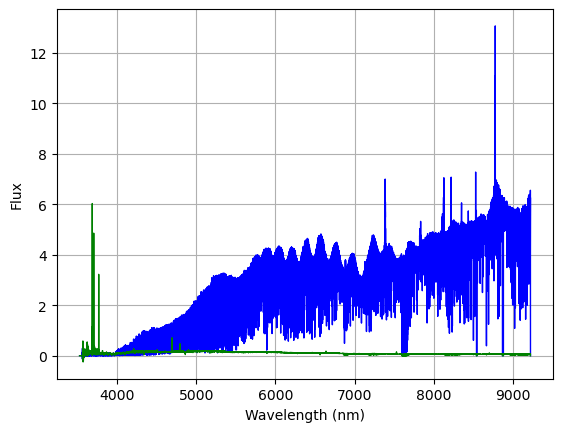

In [38]:
from ispec import plotting
plotting.plot_spectra([tp,hd])
#print(hd)
hd1 = create_spectrum_structure(hd['waveobs']*.1, flux=hd['flux'], err=None)
tp1 = create_spectrum_structure(tp['waveobs']*.1, flux=tp['flux'], err=None)


[2024-07-25 17:11:07,087] [INFO] [643192519:cut_spectrum_from_range:4]: Cutting...
[2024-07-25 17:11:07,093] [INFO] [643192519:cut_spectrum_from_range:4]: Cutting...


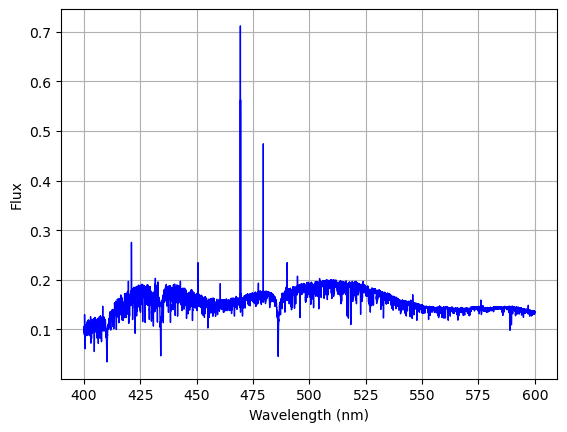

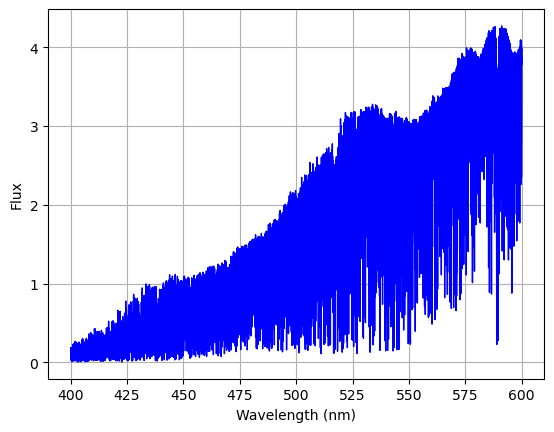

In [39]:
#选择使用的波段
hd_r = cut_spectrum_from_range(hd1, 400, 600)
tp_r = cut_spectrum_from_range(tp1, 400, 600)

plotting.plot_spectra([hd_r])
plotting.plot_spectra([tp_r])

[2024-07-25 16:05:17,406] [INFO] [2385775390:clean_telluric_regions:4]: Telluric velocity shift determination...
[2024-07-25 16:05:17,736] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2024-07-25 16:05:17,761] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 10.22%
[2024-07-25 16:05:17,777] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 20.45%
[2024-07-25 16:05:17,795] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 30.67%
[2024-07-25 16:05:17,825] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 40.90%
[2024-07-25 16:05:17,847] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 60.10%
[2024-07-25 16:05:17,863] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 70.32%
[2024-07-25 16:05:17,877] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 80.55%
[2024-07-25 16:05:17,901] [INFO] [lines:__cross_correlation_func

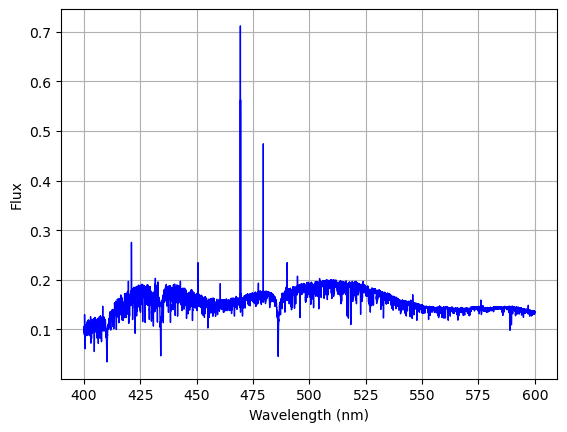

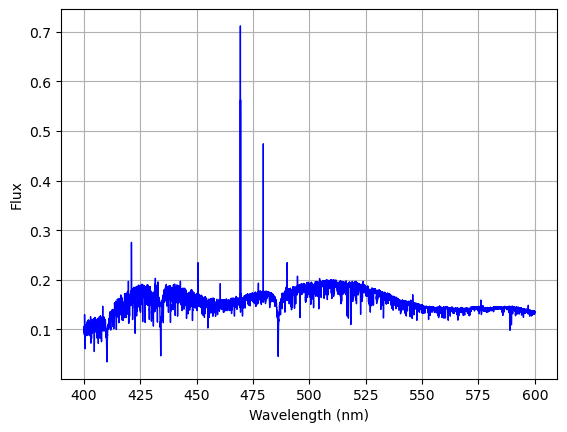

In [14]:
#去除telluric line
hd_r_clean = clean_telluric_regions(hd_r)
plotting.plot_spectra([hd_r_clean])
plotting.plot_spectra([hd_r])

In [40]:
r1 = ((600-400)/(hd_r[1][0]-hd_r[0][0]))
print (r1)

continuum_limit = 1.05
variation_limit = 0.05#两条线
hd_cont, hd_s, cosmics_hd, hd_c = filter_cosmic_rays(hd_r_clean, r1, variation_limit, continuum_limit)
hd_r = hd_r_clean

[2024-07-25 17:11:39,771] [INFO] [continuum:__fit_continuum:637]: Resampling spectrum to wave_step: 0.00600 nm (R = 66666)


66666.66815627755


[2024-07-25 17:11:39,979] [INFO] [continuum:__median_filter:307]: Median filter with step: 17
[2024-07-25 17:11:39,989] [INFO] [continuum:__max_filter:298]: Max filter with step: 333


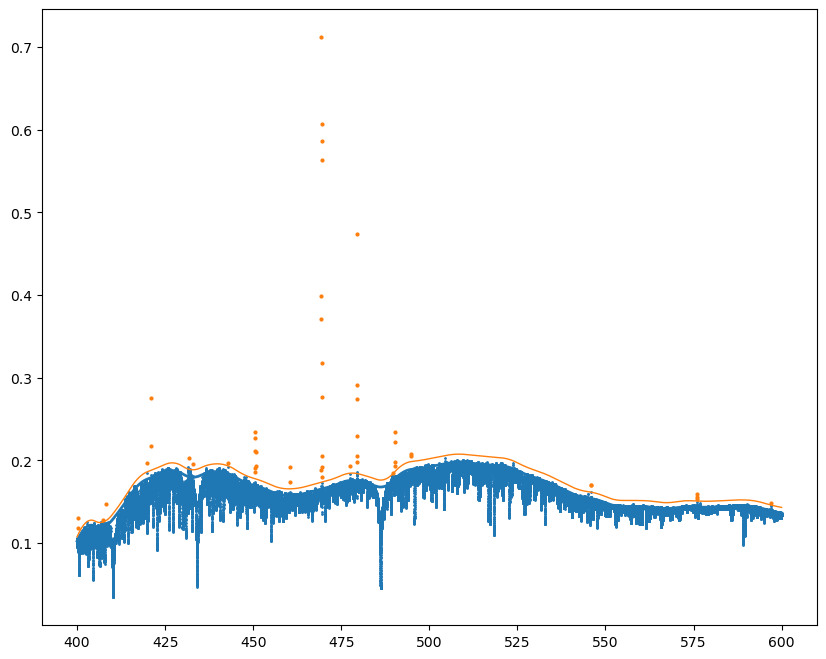

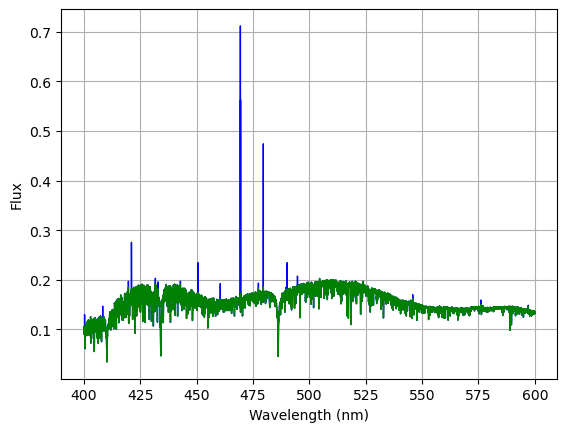

In [41]:
figure(figsize=(10,8))
scatter(hd_r['waveobs'], hd_r['flux'],s=1, lw=1)

scatter(hd_r['waveobs'][cosmics_hd], hd_r['flux'][cosmics_hd],s=4)

#plot(hd_s['waveobs'], hd_s['flux'], lw=1)
plot(hd_cont['waveobs'], hd_cont['flux'], lw=2)
plot(hd_cont['waveobs'], continuum_limit*hd_cont['flux'], lw=1)


ispec.plotting.plot_spectra([hd_r, hd_c])


[2024-07-25 17:14:14,176] [INFO] [continuum:__fit_continuum:637]: Resampling spectrum to wave_step: 0.00600 nm (R = 66666)
[2024-07-25 17:14:14,381] [INFO] [continuum:__median_filter:307]: Median filter with step: 17
[2024-07-25 17:14:14,389] [INFO] [continuum:__max_filter:298]: Max filter with step: 333
[2024-07-25 17:14:14,916] [INFO] [1845456760:normalize_whole_spectrum:28]: Continuum normalization...
[2024-07-25 17:14:14,920] [INFO] [continuum:__fit_continuum:637]: Resampling spectrum to wave_step: 0.00600 nm (R = 66666)
[2024-07-25 17:14:15,103] [INFO] [continuum:__median_filter:307]: Median filter with step: 17
[2024-07-25 17:14:15,109] [INFO] [continuum:__max_filter:298]: Max filter with step: 333
[2024-07-25 17:14:15,632] [INFO] [1845456760:normalize_whole_spectrum:28]: Continuum normalization...


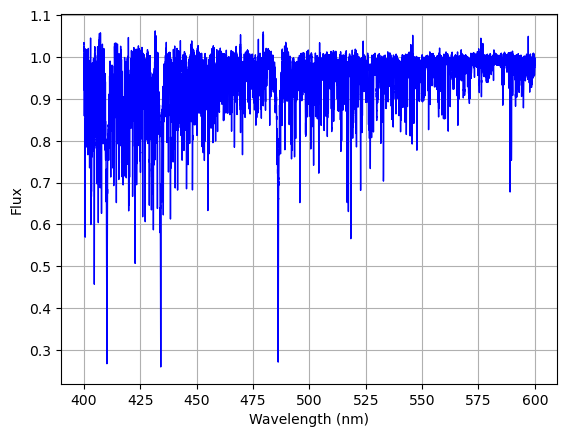

[2024-07-25 17:14:15,697] [INFO] [3795685159:determine_radial_velocity_with_template:6]: Radial velocity determination with template...
[2024-07-25 17:14:15,734] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2024-07-25 17:14:16,006] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 10.04%
[2024-07-25 17:14:16,264] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 20.09%
[2024-07-25 17:14:16,521] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 30.13%
[2024-07-25 17:14:16,776] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 40.18%
[2024-07-25 17:14:17,033] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 50.22%
[2024-07-25 17:14:17,288] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 60.27%
[2024-07-25 17:14:17,543] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 70.31%
[2024-07-25 17:14:17,798] [INFO] [lines:_

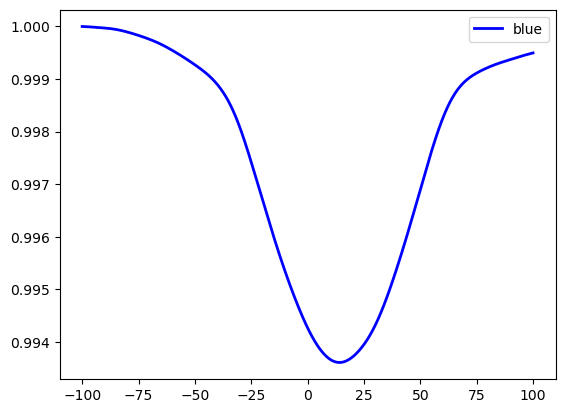

In [45]:
hd_n = normalize_whole_spectrum(hd_c, r1)
tp_n = normalize_whole_spectrum(tp_r, r1)
ispec.plotting.plot_spectra([hd_n])

ccf1, rv_rel1, rv_err1 = determine_radial_velocity_with_template(hd_n, tp_n)
figure()
plot(ccf1['x'], ccf1['y'], label="blue", color='blue', lw=2)
# plot(ccf2['x'], ccf2['y'], label="green", color='green', lw=2)
# plot(ccf3['x'], ccf3['y'], label="red", color='red', lw=2)
legend()

In [46]:
rv_bary_tp = tp_file[0].header['HIERARCH ESO DRS BARYCORR']
rv_bary_hd = hd_file[0].header['HIERARCH ESO DRS BARYCORR']

print (rv_bary_tp, rv_bary_hd)
rv_tp = -4.6 # 标准星的速度

rv1 = rv_rel1 + rv_tp  

# + rv_bary_hd - rv_bary_tp

print (rv1)

27.5679 4.85405
9.56


In [25]:
ff = fits.open(files[2])
ff[0].header

SIMPLE  =                    T / Written by IDL:  Mon Sep 19 22:09:01 2016      
BITPIX  =                    8                                                  
NAXIS   =                    0                                                  
EXTEND  =                    T / File contains extensions                       
DATASUM = '         0'         / data unit checksum updated 2016-09-19T22:09:04 
ORIGIN  = 'ESO-LASILLA'        / Origin                                         
FILENAME= 'f14691.bdf'         / Original file base-name                        
OBJECT  = 'HD-81797'           / Object                                         
RA      =           141.874931 / [deg] Right ascension                          
DEC     =             -8.66074 / [deg] Declination                              
EQUINOX =               2000.0 / Equinox                                        
DATE-OBS= '2004-11-29T08:15:39.764' / Start of observation                      
MJD-OBS =       53338.344210